In [70]:
import sys
import os
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import json
import itertools

In [71]:
flex_dir = "dynamic_res/"
minimal_dir = "min_res/"
maximal_dir = "max_res/"

In [72]:
learning_steps = 1024000 * 2
n_steps_value = 2048 * 8
number_of_rollouts = learning_steps / n_steps_value

In [73]:
def string_to_list(string):
    string = string[1:-1]
    string = string.replace(" ", "")
    res = string.split(",")
    return [float(x) for x in res]    

def string_to_list_of_lists(string):
    res = []
    string = string[1:-1]
    string = string.replace(" ", "")
    outer_list = string.split("],")
    for inner_list in outer_list:
        tmp_str = inner_list+"]"
        res.append(tmp_str)
    res[-1] = res[-1][:-1]
    return [_list.strip("[]").split(",") for _list in res]

def combine_lists(attribute_list, folder_name):
    res = []
    for file in attribute_list:
        with open(folder_name+file, "r") as infile:
            data = infile.read()
            res.append(string_to_list(data))
    return res

def combine_lists_distribution(list_of_text_files, folder_name):
    res = []
    for file in list_of_text_files:
        with open(folder_name+file, "r") as infile:
            data = infile.read()
            res.append(string_to_list_of_lists(data))
    return res

def mean_min_max(list_of_lists):
    _mean = []
    _min = []
    _max = []
    for elements in zip(*list_of_lists):
        _min.append(min(elements))
        _max.append(max(elements))
        _mean.append(sum(elements)/len(elements))
    return _mean, _min, _max  

def mean_min_max_distribution(list_of_lists):
    _mean = []
    _min = []
    _max = []
    for elements in itertools.zip_longest(*list_of_lists, fillvalue=0):
        float_elements = [float(x) for x in elements]
        _min.append(min(float_elements))
        _max.append(max(float_elements))
        _mean.append(sum(float_elements)/len(float_elements))
    return _mean, _min, _max

In [78]:
def plot_in_between(mean_min_max_list):
    _x = list(range(len(mean_min_max_list[0])))
    _y_mean = mean_min_max_list[0]
    _y_min = mean_min_max_list[1]
    _y_max = mean_min_max_list[2]
    plt.plot(_x, _y_mean)
    plt.fill_between(_x, _y_min, _y_max, alpha=0.3)
    plt.show()

def plot_by_metric(metric):
    metric_list_flex = [path for path in os.listdir(flex_dir) if metric in path]
    metric_list_min = [path for path in os.listdir(minimal_dir) if metric in path]
    metric_list_max = [path for path in os.listdir(maximal_dir) if metric in path]
    
    _y_flex_mean, _y_flex_min, _y_flex_max = mean_min_max(combine_lists(metric_list_flex, flex_dir))
    _y_min_mean, _y_min_min, _y_min_max = mean_min_max(combine_lists(metric_list_min, minimal_dir))
    _y_max_mean, _y_max_min, _y_max_max = mean_min_max(combine_lists(metric_list_max, maximal_dir))
    _x = list(range(len(_y_flex_mean)))
    
    plt.plot(_x, _y_flex_mean, color="blue")
    plt.plot(_x, _y_min_mean, color="green")
    plt.plot(_x, _y_max_mean, color="red")
    plt.grid()
    learning_step_ticks = [i*n_steps_value for i in _x]
    _x_ticks = np.arange(min(learning_step_ticks), max(learning_step_ticks)+1, n_steps_value)
    plt.xticks(_x[::15], _x_ticks[::15], rotation=45)
    
    plt.fill_between(_x, _y_flex_min, _y_flex_max, alpha=0.3, color="blue", label="dynamic")
    plt.fill_between(_x, _y_min_min, _y_min_max, alpha=0.3, color="green", label="min")
    plt.fill_between(_x, _y_max_min, _y_max_max, alpha=0.3, color="red", label="max")
    plt.legend(loc="best")
    plt.title(metric)
    plt.autoscale()
    plt.savefig(f"{metric}.png", dpi=300, facecolor='white', edgecolor='none')
    plt.show()
    
    
def plot_trajectory(last_ten_trajectories):
    for run in last_ten_trajectories:
        _xs = []
        _ys = []
        for coordinate in run[:-1]:
            _xs.append(coordinate[0])
            _ys.append(coordinate[1])
        plt.plot(_xs, _ys)
    plt.show()
    
    
def plot_distribution(last_ten_distributions):
    for run in last_ten_distributions:
        run = sum(run, [])
        _xs = list(range(len(run)))
        _ys = []
        
        for coordinate in run:
            _ys.append(coordinate)
        plt.plot(_xs, _ys, linestyle="dotted")
    plt.axhline(y=0, color='b', linestyle='--')
    plt.show()
    
    
def plot_complete_distribution(distribution):
    distri_list_flex = [path for path in os.listdir(flex_dir) if distribution in path]
    distri_list_min = [path for path in os.listdir(minimal_dir) if distribution in path]
    distri_list_max = [path for path in os.listdir(maximal_dir) if distribution in path]

    _flex_distris_outer = combine_lists_distribution(distri_list_flex, flex_dir)
    _flex_distri_combined = list(itertools.chain.from_iterable(_flex_distris_outer))

    _min_distris_outer = combine_lists_distribution(distri_list_min, minimal_dir)
    _min_distri_combined = list(itertools.chain.from_iterable(_min_distris_outer))

    _max_distris_outer = combine_lists_distribution(distri_list_max, maximal_dir)
    _max_distri_combined = list(itertools.chain.from_iterable(_max_distris_outer))

    combined_lists = _flex_distri_combined + _min_distri_combined + _max_distri_combined
    _y_combined_mean, _y_combined_min, _y_combined_max = mean_min_max_distribution(combined_lists)

    _x = list(range(len(_y_combined_mean)))

    plt.plot(_x, _y_combined_mean, color="blue")
    plt.fill_between(_x, _y_combined_min, _y_combined_max, alpha=0.3, color="blue", label="dynamic")
    plt.grid()
    plt.savefig(f"distribution_average.png", dpi=300, facecolor='white', edgecolor='none')
    plt.show()
                 

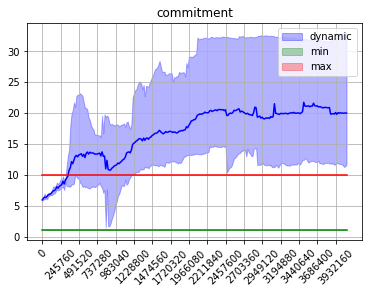

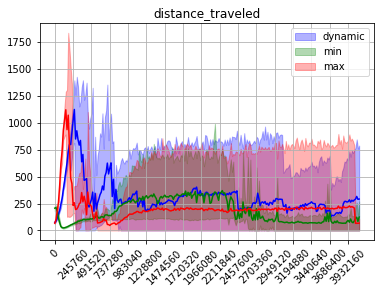

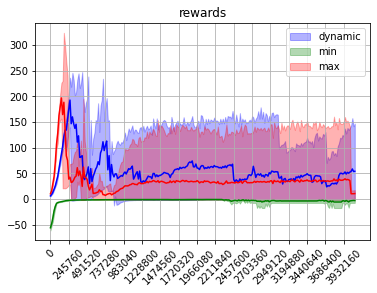

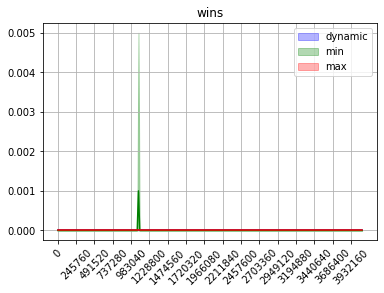

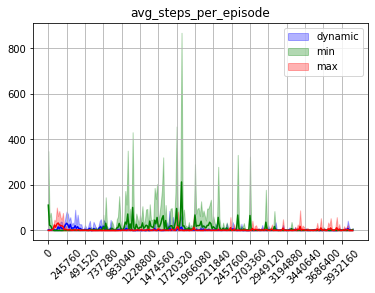

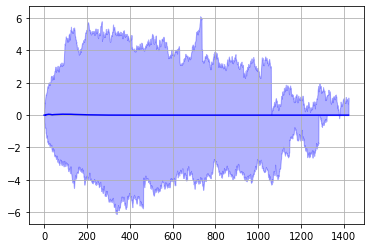

In [81]:
plot_by_metric("commitment")
plot_by_metric("distance_traveled")
#plot_by_metric("number_of_actions")
plot_by_metric("rewards")
plot_by_metric("wins")
plot_by_metric("avg_steps_per_episode")
plot_complete_distribution("complete_distribution")

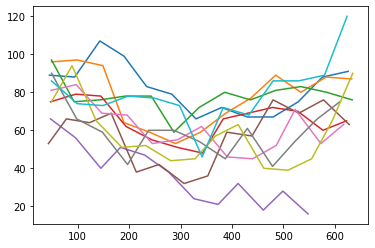

In [82]:
t="[[[45, 89], [94, 88], [143, 107], [190, 99], [234, 83], [283, 79], [330, 66], [380, 72], [430, 67], [480, 67], [529, 75], [576, 88], [626, 91], [0, 100]], [[49, 96], [99, 97], [149, 94], [190, 64], [240, 59], [290, 53], [339, 59], [388, 69], [437, 77], [485, 89], [534, 80], [583, 88], [633, 87], [0, 100]], [[49, 97], [93, 75], [143, 76], [193, 78], [243, 78], [287, 59], [336, 72], [386, 80], [436, 76], [485, 81], [534, 83], [584, 80], [634, 76], [0, 100]], [[47, 75], [96, 79], [145, 78], [194, 62], [244, 55], [294, 51], [343, 48], [383, 66], [431, 69], [479, 72], [528, 70], [577, 60], [623, 65], [0, 100]], [[47, 66], [96, 56], [145, 40], [183, 51], [230, 47], [277, 38], [326, 24], [373, 21], [412, 32], [461, 18], [499, 28], [548, 16], [0, 100]], [[43, 53], [78, 66], [123, 64], [165, 69], [214, 38], [258, 42], [307, 32], [353, 36], [390, 59], [439, 57], [480, 76], [530, 69], [578, 76], [628, 63], [0, 100]], [[48, 81], [97, 84], [147, 69], [196, 68], [245, 53], [294, 55], [341, 62], [391, 46], [440, 45], [486, 52], [523, 71], [573, 53], [617, 63], [0, 100]], [[49, 90], [98, 66], [148, 59], [197, 42], [238, 60], [287, 60], [337, 54], [387, 45], [430, 61], [479, 41], [522, 54], [566, 66], [610, 75], [0, 100]], [[49, 75], [89, 94], [136, 65], [186, 51], [232, 52], [281, 44], [328, 45], [368, 57], [412, 63], [462, 40], [509, 39], [555, 45], [595, 65], [635, 90], [0, 100]], [[49, 86], [99, 74], [149, 73], [198, 78], [248, 77], [298, 73], [342, 46], [383, 72], [433, 68], [480, 86], [530, 86], [580, 89], [624, 120], [0, 100]]]"
plot_trajectory(json.loads(t))

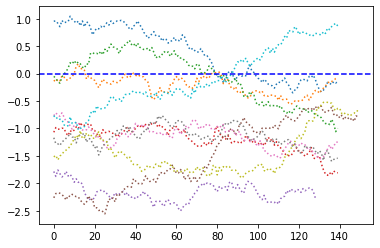

In [83]:
d="[[[0.9540078702505672, 0.9618894988699025, 0.9153670656226711, 0.8549177347914341, 0.968261144095558, 0.9238447658178615, 0.9392111849605673, 0.9443849019370867, 1.0456543080733736, 0.9880224896710592], [0.9567609170646225, 0.9180916282190854, 0.9566734392962685, 0.8708847914824227, 0.958907420917477, 0.8527456924792599, 0.9434919480198052, 0.9211552731061066, 0.8308380519257683, 0.7072480565839603], [0.7746190670758959, 0.8284119773245187, 0.8160773019309737, 0.8621148918226249, 0.831204017175094, 0.8755737050703036, 0.9272022562184296, 0.8847073394295362, 0.9599653794774383, 0.9151862118119578], [0.9306628358828923, 0.9612699704280026, 0.9615087988230384, 0.9704875329538553, 0.9597153423983493, 0.9083949998942401, 0.8778520393544704, 0.8194116001939714, 0.8024283477297058, 0.868237921908041], [0.8861649846393336, 0.9613074581089553, 0.8900684098495154, 0.8446347288431943, 0.7526157634713209, 0.7149376506653369, 0.6431156324567673, 0.6687864327762357, 0.7269615580788464, 0.7652881241865617], [0.6850135065157755, 0.6847918909802044, 0.6786019439872025, 0.5932087487290463, 0.6410232148582914, 0.624121178946212, 0.5559095616756542, 0.5915925062594727, 0.5973593457385187, 0.6613349280697158], [0.5919156958568731, 0.6044231736500602, 0.5905273234324764, 0.7090902233909637, 0.6705447132396943, 0.5641838063421416, 0.476197525619662, 0.43076929564873684, 0.4617839254767685, 0.4200500587250913], [0.38646277116450867, 0.3987647492802626, 0.45636444701548984, 0.3889141725254329, 0.3194646665661198, 0.3251358752942127, 0.2781820268247623, 0.2257387617900046, 0.12648691878409554, -0.015627371662250138], [-0.05223242368748563, -0.060696900938546225, -0.06835433470083953, -0.15762883053916799, -0.0782773220231272, 0.0016294689322633588, 0.042367492149445796, 0.03531189016487188, -0.06266347726213849, -0.12455525957889801], [-0.029410230279787293, -0.021894481816951174, -0.04809648787940141, -0.026526320014282862, -0.04136109373651977, 0.08099739327246841, 0.15060491064634024, 0.03939148328953369, 0.020620221555443075, -0.04347429404826829], [-0.08626214353718137, -0.10103807542293221, -0.1642977388416838, -0.10341471627443066, -0.14184667025715592, -0.19384149143886698, -0.2108380957213557, -0.22363336790931315, -0.26470277323248964, -0.19265225216186288], [-0.1552520660335856, -0.16428595278370625, -0.12524563378795028, -0.07990101510010156, -0.167783184783428, -0.21223432177541035, -0.2921389765363638, -0.35109842679502673, -0.29997232682989994, -0.2846553716754882], [-0.1800634970713107, -0.11621905620271952, -0.09950619658280149, -0.11814236017320195, -0.13515319560564926, -0.05252973259475315, -0.07138282068151722, -0.027424419648810757, -0.10393974968671296, -0.2090374953453492], [-0.29344465539523434, -0.33706685090028327, -0.3010957555468203, -0.2543160084354254, -0.1605636778259974, -0.17645588547555296, -0.1998224712253772, -0.14655717909590102, -0.17159459800024313, -0.14699283120691528]], [[-0.12083088349010232, -0.15108258657825352, -0.10574096843396992, -0.13226658831028237, -0.039766073267145305, -0.06286729723766762, -0.11611090683029454, -0.11565906362636016, -0.08215325612195222, -0.05402052768773454], [0.001971414304516573, 0.1403243429497981, 0.18008015117509252, 0.08389458763323819, 0.09454847314155068, 0.0605655398717178, -0.10049140796958848, -0.045765902918235554, -0.07033904654380997, -0.11256136805273112], [-0.12156822419974633, -0.1968075831273939, -0.2580687220258154, -0.17873799856634734, -0.10109631351704496, -0.14276797574224426, -0.16646333569195298, -0.18532482555858215, -0.19111483020891418, -0.14143468456605823], [-0.14573932998826122, -0.16583150979576103, -0.13287211112295827, -0.12083272018546189, -0.04164286330526533, -0.01091723360372262, -0.06405018755724705, -0.07667951843936727, -0.028201629190452687, 0.00624652503308565], [-0.026372864706091122, -0.05794171796942549, -0.03608550186517386, -0.056251520760265246, -0.05756773734149323, -0.12870277511778927, -0.14875686736240504, -0.29525765446247, -0.43299650046433025, -0.47489612314522744], [-0.4082839159684154, -0.3711102979294649, -0.25665910717916995, -0.34380002986878283, -0.3344769183022039, -0.34341176534826584, -0.3451089418081968, -0.2038568063015882, -0.20544626229127572, -0.10245641737766695], [-0.053265671780487356, -0.11253016639306099, -0.07476255125281167, -0.09434505423093145, -0.13629349324048046, -0.2145434647378633, -0.24556734839705927, -0.23126323634025694, -0.26884871078766154, -0.21288530275606857], [-0.08480569293555167, -0.14608506673249272, -0.07637370373310112, -0.09036403451511714, 0.003075899150987254, -0.08389768473402297, -0.07929480184984385, -0.0072624260601427855, 0.011189318597072898, 0.016951678318028657], [0.009551284889192154, 0.02748281288618797, -0.03789327285406244, -0.18271210056875997, -0.12658735084071449, -0.09504881420383529, -0.1945909999596992, -0.2685575626058119, -0.2780441213214039, -0.2360842962867506], [-0.3394953818783136, -0.356269168146029, -0.30845069989124496, -0.344836858863389, -0.4116166838223829, -0.44333371030180163, -0.4362137470844073, -0.3487503841438112, -0.32187104115423576, -0.3139969868964735], [-0.3164750364005366, -0.3457917630394357, -0.31999676818705014, -0.40218734709464266, -0.3959800275374603, -0.4140882479628658, -0.39242764812881403, -0.3938471823161104, -0.40792269761211186, -0.41140911603450603], [-0.48708651163760297, -0.3983359267164414, -0.4737768369408516, -0.4725961343548991, -0.46565890793118536, -0.5387267222051983, -0.5597415661724892, -0.5378152157758548, -0.4994647634318335, -0.5084436862642254], [-0.49861755701611987, -0.49947238444436953, -0.47779162924384155, -0.41787068515290093, -0.392151922103837, -0.4829786541870602, -0.4224874784910253, -0.35654438712751907, -0.30883860843356875, -0.30932917590307946], [-0.35955645393716573, -0.30434532222038296, -0.2656583865098556, -0.22601587669002385, -0.17997810729336294, -0.14037882812519464, -0.1439884046010449, -0.12494343573817517, -0.09031479194056233, -0.08045185213229744]], [[-0.05068334610003347, -0.08701889450026623, -0.14687432025862282, -0.1749970429795027, -0.0617421403666964, -0.006691098609226318, 0.031755012877644664, 0.10167719468007001, 0.19709618657058448, 0.174485700821219], [0.23741541631681706, 0.17802005749578048, 0.21282257175324962, 0.17695927534702666, 0.11762182768264665, 0.09768763958012477, 0.1803688153622749, 0.1674703144738967, 0.374383247829996, 0.38143427819018993], [0.35883359253818575, 0.369868977145678, 0.3481865863217037, 0.4094784918122755, 0.3442165574592144, 0.44427100924838553, 0.3977387049887875, 0.46908058125651075, 0.5386433748841406, 0.48976270562070534], [0.4689929874889003, 0.4511789323066063, 0.3639361847289765, 0.4538406614434894, 0.5171930114239979, 0.5196540692443447, 0.565318746524197, 0.6089886877443214, 0.5290931755306869, 0.5544061456227339], [0.48844492282577595, 0.5576867164187834, 0.48463534250122076, 0.456457800144909, 0.4400855856301653, 0.4349561007162691, 0.4658033503506521, 0.42372428448168503, 0.47507933155917, 0.38511582814496176], [0.28289034042101635, 0.3261193087108197, 0.30124136326201745, 0.34822936323735343, 0.39982281957746957, 0.37206566877114944, 0.39442813895839574, 0.3135028579258352, 0.3714816369504063, 0.4163545110973448], [0.31079914092744754, 0.3266899620107408, 0.2830333599256884, 0.2830074187370263, 0.23614750892539604, 0.21644898954240147, 0.152983090405366, 0.12580969656743327, 0.1356527822976393, 0.08714522683551747], [0.17234273426070065, 0.1694867714823984, 0.020845171030867242, -0.004772554231988417, 0.018550665156259194, 0.04462027792481307, 0.13870728435192747, 0.10471187959089195, 0.056308407317951836, 0.010129690612094174], [-0.029110752470327808, -0.04140777528109125, -0.06256036627489775, -0.03978880866601903, -0.0354765239517922, -0.106391795627997, -0.14387721770807574, -0.15997584240850943, -0.1100769494778425, -0.08406607784308917], [-0.18754695700092835, -0.1643265093009188, -0.2355765586368885, -0.41284117156986266, -0.4018042508241698, -0.4140957607110962, -0.3278976580905511, -0.3847501845842062, -0.3954104276836408, -0.5275464791204408], [-0.5798202949822356, -0.5570830235691735, -0.5186777482875833, -0.6036211935848739, -0.5652920946858003, -0.5118638021279085, -0.593618605633548, -0.5818530909897438, -0.5853360769331858, -0.575931611901034], [-0.6266561874630961, -0.5873631756690156, -0.6521316298098931, -0.7004668239808531, -0.7214637067897143, -0.6772682690061977, -0.7324218248088565, -0.7027930245155816, -0.6278379807620751, -0.5899507796553913], [-0.6259950854449321, -0.6483505800197664, -0.6462461307516838, -0.6318520945937836, -0.7083102709479142, -0.69585914188301, -0.6713756480977672, -0.7021245484996383, -0.7563984464843798, -0.7631203489730851], [-0.7702603379930979, -0.8078013295325868, -0.8726867198381429, -0.9124692820850573, -0.8992454436555484, -0.9291468091515774, -0.8326521268716665, -0.9073885113446709, -1.058268194019792, -0.9975190458372456]], [[-1.0704832508163027, -0.9839437295077682, -1.0148731613731208, -1.0112057334266051, -0.9958127444724858, -0.9987003474164062, -1.0858203680079108, -1.1299866999809922, -1.0410438393757484, -1.0650242641623393], [-1.0282194913201055, -0.9710074774412296, -1.0050450610060953, -0.8900445879444575, -0.9561899943180012, -0.9417036033247752, -0.9224165562511293, -0.9273801180415204, -0.9171859636500089, -1.0335973838765287], [-1.0378529230284244, -1.0922573903725221, -1.1480484618777378, -1.134274510943972, -1.0222367648532218, -1.077890223978407, -1.0662984025909679, -1.0515070382087452, -1.0796246941378964, -1.0896261446965538], [-1.1075873640526133, -1.1553523068750469, -1.1046132205885908, -1.1016490986828327, -1.0744122407687637, -1.0115411822648586, -0.9838155028303254, -1.0504451034206777, -1.0682946808848284, -1.0418014045374322], [-1.0011196226544667, -0.9548009074935837, -0.9825186191687891, -0.936618189186664, -0.977015842768518, -0.9282434123275061, -0.9131481719067387, -0.9527546360057024, -0.9121909861212677, -0.9113923711362768], [-0.8989213398803715, -0.9809199057066278, -0.9345572325637959, -0.9686674474104742, -0.9949787392791315, -1.0431388626558618, -1.1280751095352224, -1.011173031339185, -0.9946059712455975, -0.9903418122361499], [-0.9650435394337435, -1.0160696636510689, -1.0526861762362023, -1.0837539003844356, -1.019393958804027, -1.1578046250319445, -1.1878748292619754, -1.21425207002583, -1.246413414100028, -1.2867114453714217], [-1.3241727580805538, -1.316590896863354, -1.3258065365864586, -1.2918584495657428, -1.2520336108523604, -1.3127476350559553, -1.2607467845809373, -1.287593953382191, -1.2234436053126756, -1.0359789172582834], [-0.9532058661363346, -1.0787221684123838, -1.1366182852018705, -1.1832795707194022, -1.1971461262075676, -1.1394081531789435, -1.1394140564122692, -1.2642297393957618, -1.2324311284202945, -1.2504250220161257], [-1.2471440327457972, -1.2768094214627423, -1.250710041604798, -1.2480778941631456, -1.1250419876691777, -1.169969757696402, -1.221000094958463, -1.2543669611418757, -1.2188799098014131, -1.2660613438744501], [-1.270722495219513, -1.3044245440881486, -1.254037059525631, -1.3145670754091858, -1.2413588002657274, -1.1593440099300445, -1.2208112765921992, -1.1931345849134853, -1.3054044689322901, -1.2429850258141655], [-1.3353327360123388, -1.3539188527095463, -1.401346943560489, -1.4525068450376748, -1.4966224846511111, -1.4953096692953571, -1.5020439878097198, -1.4449542502898738, -1.3901067821320947, -1.3511999817237368], [-1.4120186338340104, -1.4154869641880619, -1.4630741473887523, -1.5064846531025158, -1.4691554226579067, -1.4475463571548635, -1.3485282361267283, -1.5393418195522122, -1.5504468212078897, -1.5229833183370065], [-1.4994199186207124, -1.6464179293023231, -1.754326392842322, -1.8330099057327334, -1.8550448745082055, -1.8063089238977297, -1.850504132592399, -1.7735995520965415, -1.8086226563115722, -1.8085415016696724]], [[-1.7845579639866442, -1.87519869064062, -1.7586290046932807, -1.8254773032910538, -1.8843942069310744, -1.8585981858750733, -1.7806747941198386, -1.8677050637034056, -1.8368859537340445, -1.8926209043128635], [-1.9816418334495531, -1.9188800206547183, -1.983659952999283, -1.9718496267980856, -2.019223323258622, -2.1697953285695384, -2.237533367836181, -2.3064922046064593, -2.286423242917222, -2.289326635365221], [-2.2673169161962594, -2.1585876106875617, -2.1368085103248666, -2.127265506875847, -2.1566156142529085, -2.1421038792028275, -2.1887941997773295, -2.231556235584133, -2.2840896889937445, -2.2478110858948823], [-2.1731051338947176, -2.2147713180901363, -2.1991868169249287, -2.1743569371470244, -2.1454185536192, -2.2228022646803125, -2.167858909809421, -2.2422695619786146, -2.254375081993772, -2.2444255918631857], [-2.2852996714598355, -2.2531295079384286, -2.2101140136189876, -2.2161052922749436, -2.144043676420086, -2.2152375476372654, -2.2207821163845276, -2.2431930336358628, -2.3689246601852787, -2.435531497425548], [-2.3300428689451507, -2.3330822720563456, -2.32794204074253, -2.380590506353938, -2.4205201953495976, -2.3153673425123613, -2.2970361408094258, -2.376699362798377, -2.3670360080954405, -2.3561476268768486], [-2.3727501354387965, -2.4567471007387782, -2.5048255691104204, -2.452206622405313, -2.3914332558191944, -2.3811794251335128, -2.389351067581981, -2.266283595658248, -2.2526875409032017, -2.1817072784641973], [-2.1440724691554944, -2.0597463275216503, -2.0460598953954863, -1.9938795973858796, -2.0361026579864903, -1.9957830589242347, -2.016261551984609, -2.01256139717705, -2.0325056111653526, -2.107474862507881], [-2.1538724473968593, -2.0625130223763364, -2.0984633371875896, -2.0655374980172163, -2.06393339721003, -2.1265471493031236, -1.985875812459275, -1.973341306546707, -2.100320242477377, -2.0933518687553923], [-2.0239088343488874, -2.098758555976239, -2.149442005737958, -2.1824138492245164, -2.0298794910912386, -1.9650222415402343, -1.9805627576704956, -2.0118111532017475, -2.058029948385772, -2.1314977107660593], [-2.2012924506725358, -2.2594671837425837, -2.299029616671132, -2.2207382281474306, -2.32035562942254, -2.356984877219481, -2.348263760247105, -2.3354511675403904, -2.352652939397683, -2.328970504308456], [-2.380769096266989, -2.2836728118761056, -2.2438469169189936, -2.237843630702716, -2.135006262479733, -2.1794355081591616, -2.101561674370416, -2.1326179696832583, -2.15419617790695, -2.110794440063609], [-2.1222563918290316, -2.1663621671790807, -2.0969959042659294, -2.136267492503486, -2.113400680128793, -2.084653362214327, -2.094725535932933, -2.1419995915700256, -2.2643955044647037, -2.2724803173906096]], [[-2.2649842716757784, -2.1871148322323575, -2.1732279448113037, -2.1821798442087212, -2.2095475377256966, -2.241038907558342, -2.3052918503146302, -2.2249042729127, -2.2436949324411506, -2.202211723228519], [-2.2194300204727355, -2.2459871491844363, -2.248621893967826, -2.308381233081346, -2.35179422008226, -2.3838884669703404, -2.3408951766367867, -2.2288926677106105, -2.3034152578147022, -2.28738979677714], [-2.447153882759219, -2.4463740463061887, -2.495910235220617, -2.4877435124436977, -2.516973977701059, -2.5586838590921004, -2.422776802990868, -2.283420265131606, -2.3055612458900487, -2.266856253129673], [-2.3394171322441912, -2.195658298775958, -2.217628806191594, -2.1888177519533754, -2.1178729315952465, -2.096540187115795, -2.061732707508032, -2.0588415862673353, -2.0714865168063272, -1.915768412938398], [-1.9565027693274528, -2.0011730890858246, -2.0078897540019156, -2.0161533884400358, -1.9533458304360147, -1.8627653755263198, -1.9254039461056678, -1.9676372111724738, -1.955748724218605, -1.927520071209373], [-1.9792727544246154, -1.8976900453565326, -1.8021288385014302, -1.8104753756173182, -1.8314654430130968, -1.7698144201354986, -1.7715172279763336, -1.7377018071124375, -1.6709202710919981, -1.7327815956737973], [-1.8174180672798803, -1.8153626467024122, -1.7489547079966135, -1.7876365970556067, -1.9328336815510774, -1.8877718150071647, -1.8544418770145057, -1.9687980331636399, -1.9259715033072515, -1.8737440504260976], [-1.9638218823570956, -1.9366031152219116, -1.8558268652382282, -1.792939540969894, -1.6826971218998734, -1.7202815351152099, -1.641121371412959, -1.5424169446929112, -1.4843093974862867, -1.4188299390848793], [-1.2920570672480371, -1.2692346490822184, -1.2069290517062334, -1.1210443357156477, -1.1467988002581875, -1.1969544098235516, -1.001281971243657, -1.0306982126145503, -1.0407858497742808, -1.103022372960283], [-1.033564992366827, -0.9223263170320736, -0.8901127506919638, -0.8000449859922242, -0.8792572644123734, -0.9050689002984849, -0.9471831716344695, -0.9743845239155616, -1.0721938779630107, -1.077348773311523], [-1.0609506112139009, -1.070557397306749, -0.9953558858825764, -1.000320410193207, -0.9965794942912154, -0.987389907566051, -0.9970642539346807, -1.0018167552568602, -0.9355808837489091, -0.9789618277007828], [-1.006644962139325, -0.8826639714210489, -0.8623571858728554, -0.7991743513733198, -0.7545190279375849, -0.8193574322001237, -0.8326662016260802, -0.8570449724755002, -0.8622362002077975, -0.822686050780957], [-0.7789426191376723, -0.722116218357427, -0.6494488006908947, -0.64692392926381, -0.6513290183170763, -0.6316059289810203, -0.6317526576311034, -0.6752151065411285, -0.5987880612283777, -0.6441308630782896], [-0.5841524179921322, -0.5992182446418914, -0.7030546456336608, -0.7021669973376572, -0.6981871587755131, -0.6539100084032763, -0.6163214988690355, -0.7382407785335342, -0.7739437418380806, -0.7480135817456739], [-0.8101035617312606, -0.7619218058977532, -0.8434487797421724, -0.7851162634071028, -0.808912775003757, -0.847906429447143, -0.8073669068432932, -0.8705506686383477, -0.771430596649098, -0.7887639276806995]], [[-0.7684012732250483, -0.7146056938924834, -0.7605542037583662, -0.7793069423820107, -0.7152737966327247, -0.7915094690130275, -0.8740521598937634, -0.8813657722035241, -0.9573941847505911, -1.012975660633948], [-0.9431041696261664, -0.8952712274243503, -0.8868827439057774, -1.0058790572276022, -1.027294400832513, -1.0391512687610767, -1.0246269262936485, -0.9733937983002507, -1.011112433069038, -1.0707226483122891], [-1.1146983858932007, -1.1826164616177508, -1.1393598020905114, -1.1677918252121418, -1.202235214553748, -1.3269424033160047, -1.3503074525736407, -1.3617376885367296, -1.3464434627435133, -1.3097566126842024], [-1.312346244605168, -1.1855658794088804, -1.1533686436492026, -1.091041596955144, -1.0970249885292742, -1.0952060962251509, -1.1506244527736635, -1.1472756671665156, -1.0684288424273385, -1.0565411818212134], [-0.9079372722656214, -0.9444959169510133, -0.9563595680903912, -0.9489332077005097, -0.9246523658204909, -0.9777725301196816, -0.9873350756752357, -1.0636383660075786, -1.0606546839486655, -1.0602255060504957], [-1.0824874994992477, -1.098348142375127, -1.081749504699562, -1.1249781439623852, -1.0915748724143206, -1.1012438743320971, -1.137880382234754, -1.1496203614949851, -1.1771992192813678, -1.030102529233465], [-0.9941379816968531, -1.0304544184612805, -1.110501284650193, -1.0621742834843406, -0.9987186650150224, -0.9495517512204408, -0.9872118288087517, -0.9335845956140973, -0.8537160001160589, -0.8383751489603458], [-0.8893038418338965, -1.0136320536994605, -0.9772776290902486, -0.9958741752587977, -0.928721904913986, -0.9369062973115432, -0.9248133365565915, -1.00440894787013, -0.9906861242795552, -1.0180485751189647], [-0.9627555105471202, -0.950547686124149, -0.9781650465070785, -0.9287596943462062, -1.066664141951592, -1.0620670755374997, -1.0429612166000377, -1.020209926299974, -1.0448365936017812, -1.1326394218954747], [-1.078206984182338, -1.0568253960631264, -1.1854322531191093, -1.2242748842047657, -1.20835833205576, -1.177535282762976, -1.2390524789575907, -1.225523593821557, -1.1830139263937833, -1.2881613520490576], [-1.325013401231745, -1.2260629662802949, -1.3085491316124618, -1.4087495848399334, -1.4138630556952816, -1.4713227526975108, -1.4943244598696794, -1.5120595292299501, -1.4815266272714178, -1.490214254195413], [-1.5423308106237554, -1.5323563944093443, -1.4383220200838411, -1.3647012426451488, -1.3246137877122668, -1.2517140338133261, -1.233823216983751, -1.312811324096879, -1.2893424287302124, -1.306908550402261], [-1.307950842348835, -1.2626171709446654, -1.2978870067162616, -1.2988007313529886, -1.360293129156119, -1.3488908917977669, -1.4278694810516108, -1.4156544135403406, -1.464273249839805, -1.51975298845543], [-1.5597828607943938, -1.5396041549507875, -1.5145327939129856, -1.4443293691547332, -1.3774542984218365, -1.2992263431620326, -1.3841576786907717, -1.331282888154353, -1.2536447266688289, -1.2479561307078912]], [[-1.169413376450865, -1.2796134041414942, -1.2813824291938931, -1.3113622730542915, -1.2419537104720013, -1.2221661223606919, -1.179857699427914, -1.1459261339810887, -1.0842117033284229, -1.156040534400138], [-1.160121443023992, -1.2635350934915723, -1.1461837108382502, -1.1101764906414218, -1.109044000552026, -1.0898007189851797, -1.25048353787075, -1.1825535268791618, -1.194021068551879, -1.2763580280919733], [-1.3608442202124091, -1.3124914810495745, -1.4845241246990475, -1.4077026284388836, -1.311507539936387, -1.2860046525320572, -1.2467237014779275, -1.2109492185120756, -1.1607598836085096, -1.1471400997554344], [-1.1137316362411354, -1.0368677151556713, -1.0898760678535107, -1.030062867558423, -0.9570219067742014, -0.9592829830949088, -1.0628215655812372, -0.9616860992918517, -1.0306973146109184, -1.1005294243704382], [-1.1230645173755094, -1.1794180028117216, -1.190470610225693, -1.0954711309026344, -1.0617672865820227, -1.007818254834555, -1.040608304548452, -0.8817853192557343, -0.9214324794028027, -0.9041083350095972], [-0.9103880987137005, -0.7718272690465497, -0.8356538122365913, -0.7640930051073063, -0.8049111065073974, -0.8548182975823554, -0.8840593035355822, -0.9557858012958992, -0.9664119401490353, -0.9582331983438617], [-0.8622039931413602, -0.8584447776857356, -0.8613605011096782, -0.8917674982320034, -0.9634197647498353, -1.0500982072460938, -1.1248900426570967, -1.0971263338379285, -1.1164596603810455, -1.0866342578816912], [-1.1354094435273887, -1.1402189639525717, -1.1942622078032723, -1.1978176566463152, -1.1613773861194874, -1.1395865210816425, -1.1488600005525482, -1.2463064956787202, -1.2214682876900453, -1.1971522416021285], [-1.1656022252320437, -1.117842053949178, -1.067524191785732, -0.9173232562694176, -0.9170429126722475, -0.9408562941202299, -0.8795874321216284, -0.8999744206118037, -0.8552963841564076, -0.8683511345374656], [-0.8717658379444578, -0.9239809519741602, -0.9455851082759359, -0.9655351988098282, -1.0717459417455615, -1.145805868792343, -1.1872774624493991, -1.226439019156366, -1.1923899507076627, -1.1729343040991682], [-1.1379690115355698, -1.092143885545035, -1.0545375149561635, -1.0733574406309128, -1.2395571648190087, -1.2125729266742122, -1.2364424418529683, -1.1931183073682383, -1.2649540864872506, -1.1950938002134879], [-1.2425737397476644, -1.2934863597066668, -1.2640017841564304, -1.2341955039668897, -1.207035322978166, -1.204915850570334, -1.2869239092197131, -1.3305502971881982, -1.281495222804924, -1.3611254126022545], [-1.4479010592749413, -1.444529453060622, -1.4214766548033637, -1.308737915036453, -1.348547089787897, -1.3625102882571731, -1.3372972559413265, -1.3456620099088652, -1.4127815187178845, -1.4640208544180677], [-1.4058550947787944, -1.4495127847013576, -1.5836794576819988, -1.4345050677102749, -1.3988269605013768, -1.4975672714285424, -1.6020094450833526, -1.5675650511138202, -1.542406531776896, -1.54456780250089]], [[-1.5181919416757914, -1.4918069002209196, -1.5745622932295733, -1.5023199521577864, -1.4758898799497808, -1.4175301823375046, -1.3960181643643184, -1.3681951736572695, -1.3221412061471904, -1.2574722253747166], [-1.1909472712482414, -1.1231807780830576, -1.172810936847469, -1.0409337620833354, -1.185455410032738, -1.1650535464070426, -1.0859011283368016, -1.1279380100958247, -1.1035254665697731, -1.1801173274746464], [-1.1751738246285235, -1.1216367587506364, -1.0590576193098917, -1.211647458471553, -1.2094080483366823, -1.2405937638136684, -1.2416602687475806, -1.4006040255572538, -1.373648292546909, -1.4451597266361573], [-1.5350043436106584, -1.4748652107118985, -1.4123951169171438, -1.4312233655122548, -1.4480336028328795, -1.4958785568682273, -1.5379413800225388, -1.5114132685097594, -1.6072604438510423, -1.6569867819011586], [-1.6610211418017509, -1.6611181323177262, -1.70161454622131, -1.7819935966143285, -1.7738126787997563, -1.7316904020318904, -1.6717956630536905, -1.7002456055271882, -1.6953234377920616, -1.714394168373277], [-1.6483394551646753, -1.6646800124683279, -1.7208312843066969, -1.6053613507185338, -1.6156233445298303, -1.5957054377465636, -1.6557124498341524, -1.67298457048903, -1.668264828241107, -1.7913842505826354], [-1.7739209725715823, -1.7773074201798575, -1.7871462688073287, -1.7897679402846136, -1.7711733738092255, -1.7270447549570573, -1.7782193103012593, -1.8125522921337263, -1.8032514888496964, -1.781740449775261], [-1.6978140813066922, -1.7616981969427423, -1.7371928005646535, -1.7165788826722423, -1.7945086360835747, -1.8661293877916338, -1.84200361545847, -1.8632017029311472, -1.6767110911156564, -1.6752534568946422], [-1.8478218315628452, -1.71254332618708, -1.7696998654305187, -1.696689911592868, -1.720390945536269, -1.6838591358622526, -1.6951646074172841, -1.7616241074887051, -1.7607659605528658, -1.7605781542989505], [-1.8080844803533775, -1.866887553973177, -1.9057314046032559, -1.870052872638762, -1.81849552151931, -1.790239168242195, -1.7783486000157618, -1.7800507445969638, -1.7507933093486414, -1.6938079923928635], [-1.6702416791926624, -1.6831719024205807, -1.6498515681347172, -1.76937565842208, -1.7805823921769166, -1.7272995248315763, -1.7455493456830435, -1.7497097480533466, -1.823427137968098, -1.7266478093576452], [-1.7355841963896896, -1.696451984289277, -1.6471706793489553, -1.521940258349353, -1.519068417414491, -1.437310847936179, -1.363438566151667, -1.3466874424776731, -1.2417228969847534, -1.1779007575090492], [-1.1256142233991682, -1.1862974429523925, -1.1179614140746017, -1.0494581604236266, -0.8695257565747355, -0.8586240973204722, -0.874388002658152, -0.8600426822176224, -0.7608317307392125, -0.6186264133078226], [-0.6320135439384277, -0.5640599679151622, -0.5252684278474491, -0.5174134337323654, -0.5250662043938528, -0.5433462355128675, -0.5377352197423348, -0.6359291271810793, -0.6772063545457851, -0.6348634593502666], [-0.6343197443269559, -0.7305953390677118, -0.7086790144474799, -0.7507673430481563, -0.7450720286169095, -0.7733516738706842, -0.7397396006872097, -0.725308561683829, -0.6784051161882949, -0.681208999743648]], [[-0.7667800301434706, -0.8203552306098685, -0.7988779393806464, -0.8333873507157781, -0.84151045674227, -0.9342838472872903, -0.9619985351346346, -0.9499735406338923, -0.7889291799708182, -0.9083564175075063], [-0.9087377971053539, -0.8845868365981875, -1.026699891357513, -1.0003489843578572, -0.9817154630844958, -0.9662525448015777, -0.878914761310335, -0.8551402218668506, -0.7251294592640354, -0.6753646113293833], [-0.7264867159745578, -0.5894287630456265, -0.6449978289501336, -0.6421922906664459, -0.6342936831424187, -0.6265066544631508, -0.5925899604537861, -0.5187928931404285, -0.4179789594441181, -0.42819529172345117], [-0.4879056090368494, -0.47151888376534346, -0.45998280256899315, -0.5138474727235813, -0.44554768566271974, -0.3811689560886762, -0.38315207743090796, -0.37305102188923234, -0.33960601031879867, -0.31756208857169854], [-0.33771565435133666, -0.35771099154587, -0.3438248840054645, -0.3428012264041696, -0.37306564732592795, -0.3356315746886652, -0.4253019555034877, -0.42160585156613833, -0.4078842134584142, -0.39608227476920066], [-0.34259282101079586, -0.42747787567767487, -0.4749353411007421, -0.3859931639208769, -0.3419298627541778, -0.33532998287561655, -0.3647017017512326, -0.3189140988370499, -0.3963603570114439, -0.32957804350838604], [-0.2781097269748065, -0.26847583441244816, -0.29206444645679847, -0.3209702637359999, -0.3844363089848455, -0.37413019169484385, -0.42299008230682467, -0.4482337475137563, -0.2794167204508789, -0.35763604688382034], [-0.2546619281260194, -0.179129222130462, -0.2451587429594559, -0.23452565941475978, -0.24802110497705787, -0.18567255650725023, -0.22193348206269276, -0.19014119059951223, -0.1388481006319227, -0.15284128111781387], [-0.12557955228473527, -0.12875560196973077, -0.0392402829114854, -0.1186063571124779, -0.17032669131126538, -0.08146198976535066, -0.053679857265554916, -0.008826193079994863, 0.04813810714326293, 0.14562070809828634], [0.21544515722584548, 0.20007684623267485, 0.26072140972254954, 0.22141030208781032, 0.2785564112975053, 0.1995758097945579, 0.13245209704552158, 0.1788631225601851, 0.22538041957196214, 0.25783885293210396], [0.2871841632785291, 0.24857498806499956, 0.31670863171618147, 0.4101661751879073, 0.4412182807165522, 0.469593663047131, 0.3706583992882191, 0.46465903959633575, 0.39072771850102406, 0.48589832783573506], [0.5285804525974973, 0.5199786640035563, 0.5856327226629167, 0.6770844473485724, 0.6452268335819359, 0.7903001989952554, 0.7643042871727955, 0.7575395347194184, 0.8579768367940288, 0.8066491207295239], [0.7141800383666761, 0.7657383773842896, 0.7530424462864067, 0.753766365226363, 0.7206854650032885, 0.6982500255866826, 0.7164701693451208, 0.6926045995415063, 0.7335693671810751, 0.7280449454451692], [0.7145991219119892, 0.7046184504650695, 0.76389196331786, 0.7312135209850517, 0.8298533435383821, 0.8021176135339558, 0.8561291889570517, 0.8890427613155385, 0.9181175709370305, 0.8687198220370077]]]"
plot_distribution(json.loads(d))

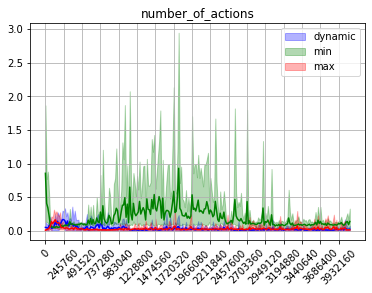

In [80]:
plot_by_metric("number_of_actions")